In [190]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [191]:
data = pd.read_csv("/content/heart.csv")

# Heart Failure Dataset Analysis and Prediction

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.

In this notebook, we will explore the heart disease dataset and will create a classification model that can predict heart failure based on a number of features. Firstly, let's proceed with exploratory data analysis of the dataset.

## Exploratory Data Analysis

Let's start by getting some general characteristics of the dataset before diving into individual features:

In [192]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [193]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


As the summaries above show, we can use 11 features to form predictions and 1 feature that we specifically want to predict (**HeartDisease**).The feature types are integer and object, where object represents a string, as can be seen from the data.head(). We will have to preprocess those attributes later on.

In [194]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


From the summary above, we can derive some insights about the data. For example, the average age of people in the dataset is 53.5, with the youngest person being 28 and the oldest 77. Another interesting observation we can make from the summary above is that **Cholesterol** and **Resting Blood Pressure** minimum values are 0, which is impossible for a living human being. Such values of 0 probably suggest that this data is either missing or incorrectly recorded, so let's further explore the rows with 0 values for **Resting Blood Pressure** and **Cholesterol**

In [195]:
data.loc[data["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [196]:
data.loc[data["Cholesterol"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


Interesting! There is only a single row with **Resting Blood Pressure** being 0, which probably suggests that there was an error when inputting this patient into the dataset. There are 172 rows with 0 values for **Cholesterol**, indicating that these are not errors, but rather missing data.We should impute these missing values with the mean or median, but before that, we need to determine whether the distribution of both **Cholesterol** and **Resting Blood Pressure** is symmetrical or not:

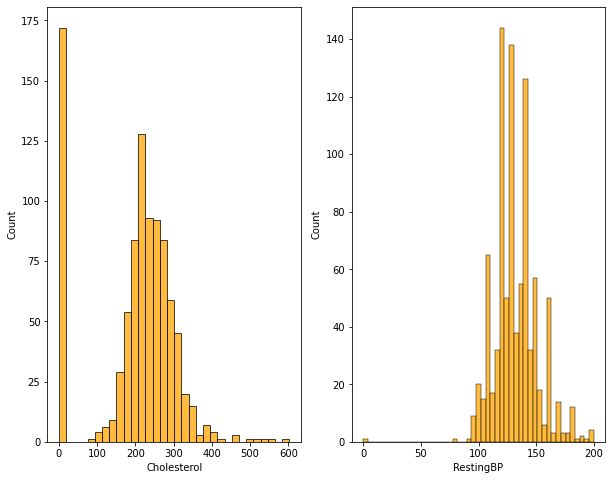

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

figure, ax = plt.subplots(ncols = 2, figsize = (10, 8))
sns.histplot(data["Cholesterol"], color = "orange", ax = ax[0])
sns.histplot(data["RestingBP"], color = "orange", ax = ax[1])

As we can see, the data for both **Cholesterol** and **Resting Blood Pressure** is more or less symmetrical, so we can use the mean to impute missing values and not the median:

In [198]:
data['Cholesterol'] = data['Cholesterol'].replace(0, data['Cholesterol'].mean())
data['RestingBP'] = data['RestingBP'].replace(0, data['RestingBP'].mean())

Let's now check that the other columns don't have any missing values:

In [199]:
data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

OK, there are no missing values. To be sure, let's further check all the categorical columns for their unique categories and see whether any of them represent missing values:

In [200]:
cat_col = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]

for col in cat_col:
    print(data[col].unique())

['M' 'F']
['ATA' 'NAP' 'ASY' 'TA']
['Normal' 'ST' 'LVH']
['N' 'Y']
['Up' 'Flat' 'Down']


It seems there are no missing values after all; we have imputed all of them. Let us now check some correlations between features in the dataset.

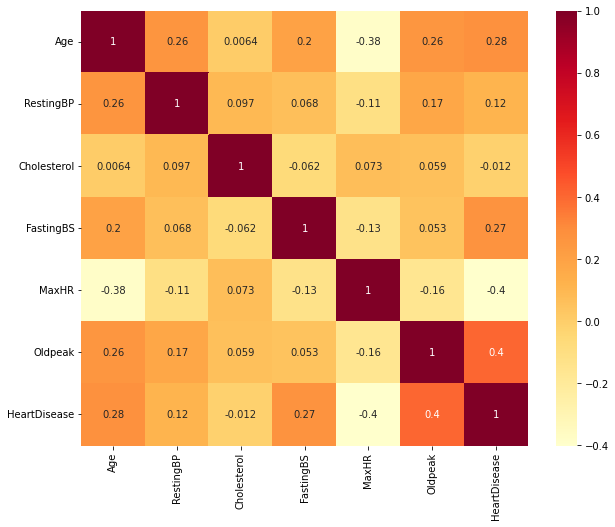

In [201]:
sns.heatmap(data.corr(),cmap = "YlOrRd", annot=True)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

Hmm, there seems to be some low linear corralation between **MaxHR**/**Age**, **HeartDisease**/**Oldpeak** and **MaxHR**/**HeartDisease**, so we might want to investigate it later on. As for now, let's consider each feature individually and how it relates to other features. But before that, let's create a countplot of Heart Disease to see how the dataset is divided according to the target feature:

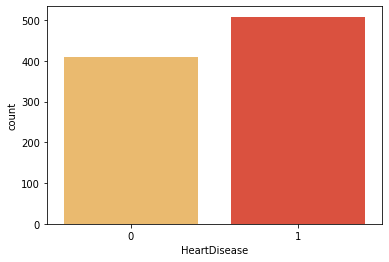

In [202]:
sns.countplot(x = "HeartDisease", data = data, palette = "YlOrRd")

As can be seen from the plot, it is roughly a 45/55 division. Now let's dive into analysing individual variables.

### Categorical Variables

Let us consider the categorical variables in the dataset first. Let's plot their distributions:

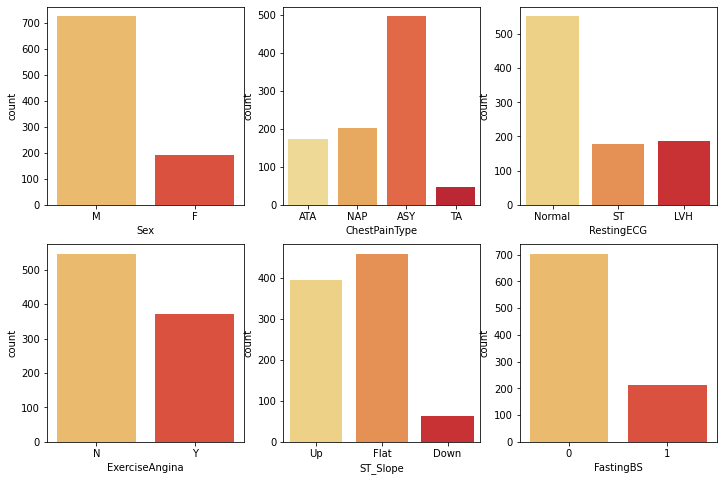

In [203]:
cat_var = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']

fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (12, 8))

ax = ax.flatten()

for index, var in enumerate(cat_var):
    sns.countplot(data = data, x = var, palette = "YlOrRd", ax = ax[index])

These countplot give us some interesting insight into the data. First of all, the dataset consists predominanetly of males (~700 males to ~200 females). Next, most patients are assymptomatic when it comes to chest pain, and few patients have typical angina (TA). Most people have normal electrocardiogram results. There is no large difference in the numbers of people with exercise-induced angina versus people without such angina, but there are still more people without it. Down ST slopes occur more rarely in the dataset compared to up or flat slopes. And, lastly, fasting blood sugar is normal for most people and exceeds 120 mg/dl for around 200 patients. Such insights give us a better understanding of the dataset and may help with modelling later on.

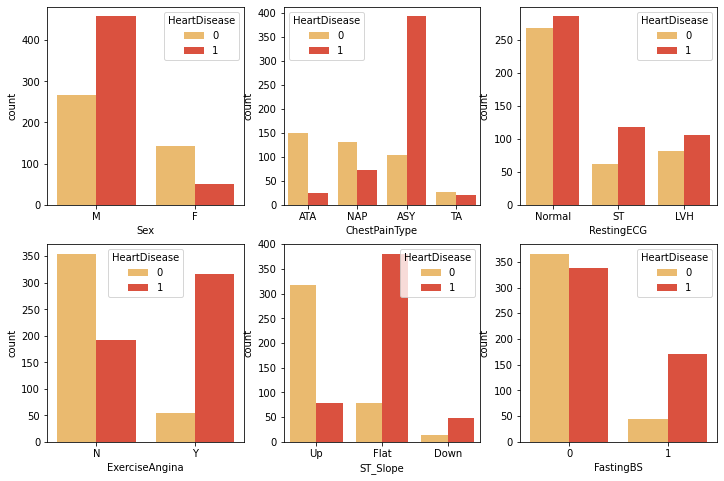

In [204]:
cat_var = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (12, 8))

ax = ax.flatten()

for index, var in enumerate(cat_var):
    sns.countplot(data = data, hue = "HeartDisease", x = var, palette = "YlOrRd", ax = ax[index])

These plots provide us with even more information on how categorical features correlate with heart disease. Firstly, we can see that most heart disease cases occur in males, as more males have heart disease than do not. For females, the trend is reversed. Next, mostly chest pain asymptomatic people have heart disease. This may suggest that chest pain is not one of the symptoms of heart disease, and people with such pains may have some other problem with their health. Patients who have ST on their ECG also seem to have heart disease more often, which may be a symptom of the disease. When it comes to exercise angina, most entries with such angina have heart disease, suggesting that it might be one of the symptoms of heart disease and that we should pay close attention to it. Patients who have flat or down **ST_Slope** are much more likely to have heart disease, so we need to monitor those features as well. People with high fasting blood sugar also seem to be more likely to have heart disease. Overall, these plots offer us some understanding of corralation between disease and categorical features, and we may want to keep these relationships in mind when modeling.

### Continious Variable

Let's now consider continious variables:

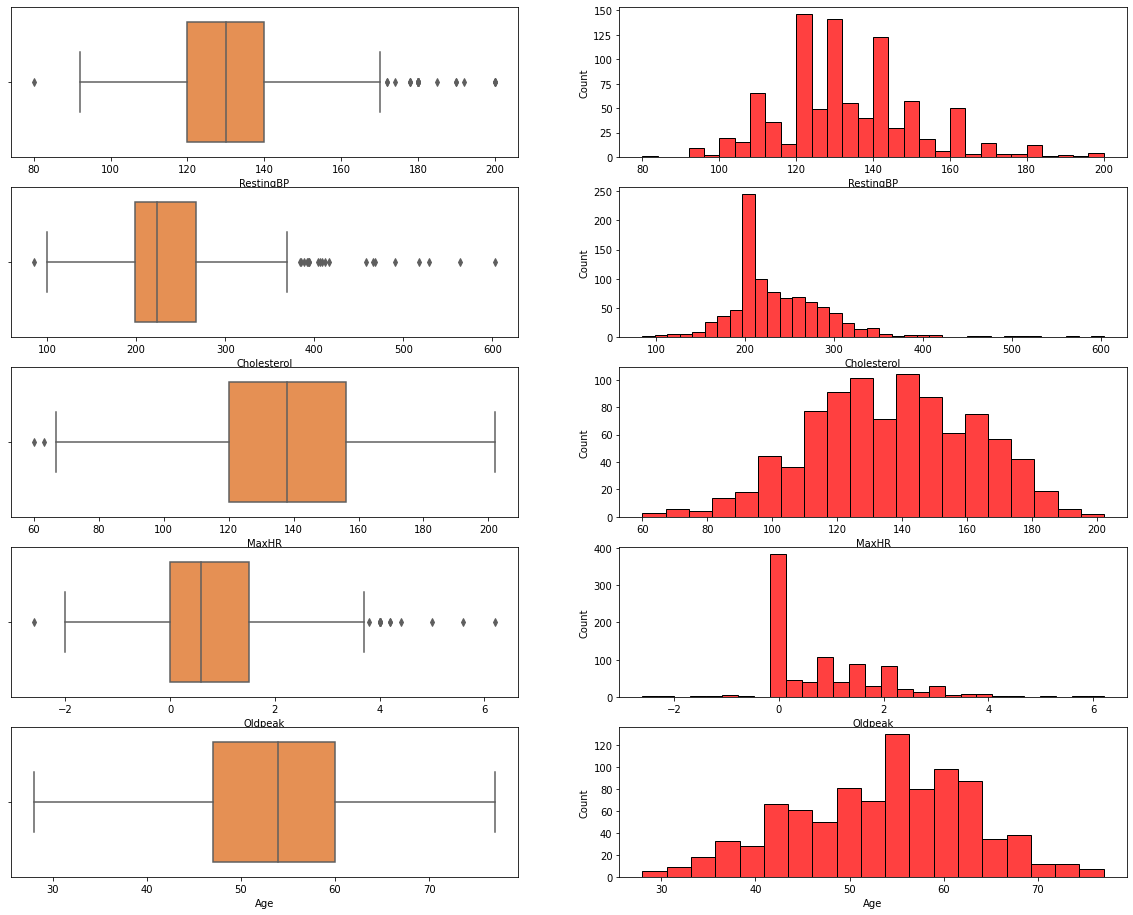

In [205]:
#cat_var = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
cont_var = ['RestingBP', 'Cholesterol',  'MaxHR', 'Oldpeak', 'Age']
fig, ax = plt.subplots(ncols = 2, nrows = 5, figsize = (20, 16))
ax = ax.flatten()
index = 0
for var in cont_var:
    sns.boxplot(data = data, x = var, palette = "YlOrRd", ax = ax[index])
    index = index + 1
    sns.histplot(data = data, x = var, color = "red", palette = "YlOrRd", ax = ax[index])
    index = index + 1

From the histogram, we can see that **RestingBP**, **MaxHR** and **Age** more or less follow the normal distribution. **Oldpeak** and **Cholesterol**, on the other hand, are skewed to the right. Box plots show us that there are some outliers in **Cholesterol**, **Oldpeak** and **RestingBP** features. **MaxHR** and **Age** have a wide interquartile range, whereas the rest of the features have a narrower one.Let's now examine how these continuous features relate to heart disease:

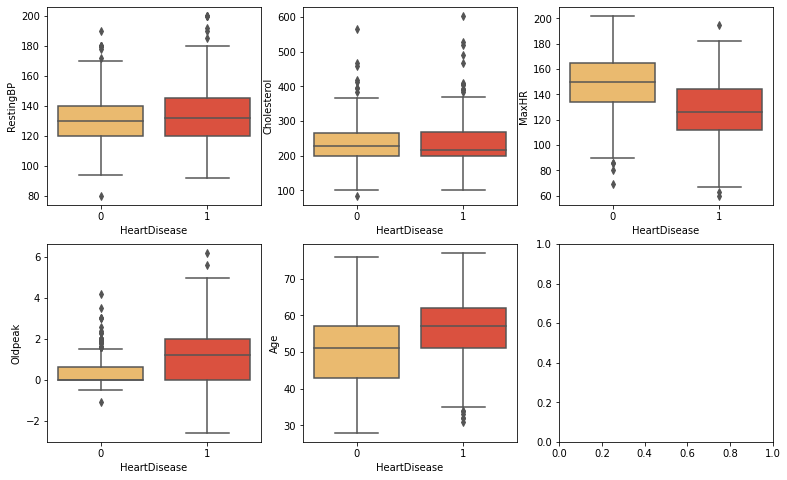

In [206]:
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (13, 8))

ax = ax.flatten()

for index, var in enumerate(cont_var):
    sns.boxplot(x = "HeartDisease", y = var , palette = "YlOrRd", data = data, ax = ax[index])

As we can see, people with higher **MaxHR** have a lower risk of developing heart disease**.Also, older patients have heart disease more often, as do patients with higher oldpeak values. **Cholesterol** and **RestingBP** do seem to have heart disease cases of similar proportions.

## Preprocessing

Now, let's start preprocessing our data. First, let's convert categorical features **Sex** and **Exercise Angina** into binary features:

In [207]:
def convert_to_binary(column, to_one):
    data[column] = data[column] == to_one
    data[column] = data[column].astype(int)

In [208]:
convert_to_binary("Sex", "M")
convert_to_binary("ExerciseAngina", "Y")

In [209]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140.0,289.0,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160.0,180.0,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130.0,283.0,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138.0,214.0,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150.0,195.0,0,Normal,122,0,0.0,Up,0


Now, we need to encode features with one or more categories. We can use pd.get_dummies() to create columns corresponding to each category in the indicator variables. The columns of interest for us are **ChestPainType**, **RestingECG** and **ST_Slope**:

In [210]:
data = pd.get_dummies(data)
data.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140.0,289.0,0,172,0,0.0,0,0,1,0,0,0,1,0,0,0,1
1,49,0,160.0,180.0,0,156,0,1.0,1,0,0,1,0,0,1,0,0,1,0
2,37,1,130.0,283.0,0,98,0,0.0,0,0,1,0,0,0,0,1,0,0,1
3,48,0,138.0,214.0,0,108,1,1.5,1,1,0,0,0,0,1,0,0,1,0
4,54,1,150.0,195.0,0,122,0,0.0,0,0,0,1,0,0,1,0,0,0,1


Ok, now we can separate our target feature, **HeartDisease**, from the rest of the dataset and store in its own variable y:

In [211]:
X = data.drop("HeartDisease", axis = 1)
y = data.loc[:, "HeartDisease"]

In [212]:
X.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140.0,289.0,0,172,0,0.0,0,1,0,0,0,1,0,0,0,1
1,49,0,160.0,180.0,0,156,0,1.0,0,0,1,0,0,1,0,0,1,0
2,37,1,130.0,283.0,0,98,0,0.0,0,1,0,0,0,0,1,0,0,1
3,48,0,138.0,214.0,0,108,1,1.5,1,0,0,0,0,1,0,0,1,0
4,54,1,150.0,195.0,0,122,0,0.0,0,0,1,0,0,1,0,0,0,1


In [213]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

With **HeartDisease** separated, we now can scale our data. Since continious features do have different ranges, we will want to normalize those ranges by scaling them. It will be important for some models later on, for example Logistic Regression. We can use sklearn **StandardScaler** for that:

In [214]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_features = scaler.fit_transform(X)

X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

## Model Training and Prediction

Now our data is ready to be trained. We will consider the following models:

1) Logistic Regression

2) K-Nearest Neighbour
 
3) Random Forest

4) SVM 

5) Adaboost

6) XGBoost

But, before that, let's import required modules:

In [215]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [216]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

We need to split the data into training and testing sets, where the training set will be used to train the model and the testing set can be used to evaluate it. We can take advantage of Sklearn's **train_test_split**:

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, random_state = 10)

To reduce the amount of repetitive code, let's create a function that will use **Random** and **Grid** search for hyperparameter tuning, create predictions, and evaluate those predictions in one go:

In [218]:
def hyper_params(params, estimator, random = True):
    
    if (random):
        grid = RandomizedSearchCV(estimator, params, refit = True)
    else:
        grid = GridSearchCV(estimator, params, refit = True)
    grid.fit(X_train, y_train)
    
    prediction_test = grid.best_estimator_.predict(X_test)
    prediction_train = grid.best_estimator_.predict(X_train)
    
    print("Test accuracy for {} is {}".format(estimator, accuracy_score(y_test, prediction_test)))
    print("Train accuracy for {} is {}".format(estimator, accuracy_score(y_train, prediction_train)))
    print("Best params are {}".format(grid.best_params_))
    
    return grid.best_estimator_

Let's start with Logistic Regression. Since not all solvers work with all penalties, we have to run two grid searches with logistic regression. Also, saga and sag solvers require data to be scaled, hence this is why we scaled data in the preprocessing step.

In [219]:
param_grids = [{'penalty': ['l2'],
                  'solver': ['newton-cg', 'lbfgs', 'sag'],
                  'C':[0.01, 0.1, 1, 10, 100]},
               {'penalty': ['l1', 'l2'],
                  'solver': ['liblinear', 'saga'],
                  'C':[0.01, 0.1, 1, 10, 100]}
              ]
               

for grid in param_grids:
    hyper_params(grid, LogisticRegression(max_iter = 10000, random_state = 10), False)

Test accuracy for LogisticRegression(max_iter=10000, random_state=10) is 0.8434782608695652
Train accuracy for LogisticRegression(max_iter=10000, random_state=10) is 0.873546511627907
Best params are {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
Test accuracy for LogisticRegression(max_iter=10000, random_state=10) is 0.8434782608695652
Train accuracy for LogisticRegression(max_iter=10000, random_state=10) is 0.873546511627907
Best params are {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}


We got the same score for newton-cg and saga solvers of 0.852, so it appears that those two solvers create the same predictions. 0.852 is a good score, but we further need to test other models to see how their predictions compare. Training and testing sets have similar accuracies, which means there is no significant overfitting! Now, let's test KNN:

In [220]:
param_grid_knearest = {'n_neighbors': [3, 5, 7, 9],
                       'weights': ['uniform', 'distance'],
                        'algorithm':['ball_tree', 'brute', 'kd_tree'],
                       'p': [1, 2]}

hyper_params(param_grid_knearest, KNeighborsClassifier(), False)

Test accuracy for KNeighborsClassifier() is 0.8434782608695652
Train accuracy for KNeighborsClassifier() is 1.0
Best params are {'algorithm': 'ball_tree', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


KNeighborsClassifier(algorithm='ball_tree', n_neighbors=7, p=1,
                     weights='distance')

For KNN, we got a slightly worse result on the testing set of 0.843. The train accuracy also differs from the test by 5%, which may suggest some amount of overfitting in the model. Five neighbours is the most effective number of neighbours to use for this dataset. Now, let's consider a random forest:

In [221]:
param_grid_forest = {'criterion' : ['gini', 'entropy'], 
             'max_depth': [4, 5, 6, 7],
             'n_estimators': [30, 40, 50],
             'max_features': ["auto", "sqrt", "log2"]}

hyper_params(param_grid_forest, RandomForestClassifier(random_state = 10), False)

Test accuracy for RandomForestClassifier(random_state=10) is 0.8608695652173913
Train accuracy for RandomForestClassifier(random_state=10) is 0.9156976744186046
Best params are {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 40}


RandomForestClassifier(max_depth=5, n_estimators=40, random_state=10)

Random forest got a similar score of 0.852 to logistic regression, but it does have higher accuracy on the training set, suggesting some degree of overfitting. Now, let's examine SVC.

In [222]:
param_grid_svm = {'C': [0.1, 1, 10, 100],
                 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                 'gamma': ['scale', 'auto'],
                 'degree' : [1, 2, 3, 4, 5]}

hyper_params(param_grid_svm, SVC(random_state = 10), False)

Test accuracy for SVC(random_state=10) is 0.8347826086956521
Train accuracy for SVC(random_state=10) is 0.8386627906976745
Best params are {'C': 1, 'degree': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}


SVC(C=1, degree=1, kernel='sigmoid', random_state=10)

SVC does not seem to overfit and has a higher test accuracy of 86%. So far, support vector machines seem to be the best model. However, let's try to use ensemble models before making final conclusions, AdaBoost and XGBoost.

In [223]:
param_grid_ada = {'base_estimator': [LogisticRegression(C = 0.01, penalty = 'l2', solver = 'saga', max_iter = 10000), None, SVC(C = 1, degree = 1, gamma = 'scale', kernel = 'poly')],
                 'n_estimators':[25, 50, 100, 200],
                 'learning_rate':[0.001, 0.01, 0.1, 1],
                 'algorithm':['SAMME']}

hyper_params(param_grid_ada, AdaBoostClassifier(random_state = 10), True)

Test accuracy for AdaBoostClassifier(random_state=10) is 0.8304347826086956
Train accuracy for AdaBoostClassifier(random_state=10) is 0.8691860465116279
Best params are {'n_estimators': 25, 'learning_rate': 1, 'base_estimator': None, 'algorithm': 'SAMME'}


AdaBoostClassifier(algorithm='SAMME', learning_rate=1, n_estimators=25,
                   random_state=10)

From previous grid searches we did above, we used hyperparameters for LogisticRegression and SVC estimators used for boosting in AdaBoost. However, the test results are worse than models above, with a test accuracy of 0.848 and a train accuracy of 0.863, suggesting a lack of overfitting. Now, let's check XGBoost:

In [224]:
param_grid_xgboost = {'n_estimators': [50, 75, 100, 125],
                     'max_depth': [3, 4, 5, 7],
                     'learning_rate':[0.001, 0.01, 0.1, 1],
                     'booster': ['gbtree', 'gblinear', 'dart'],
                     'min_child_weight': [1, 5, 10],
                     'gamma': [0.5, 1, 1.5, 2, 5],
                     'subsample': [0.6, 0.8, 1.0],
                     'colsample_bytree': [0.6, 0.8, 1.0],}

best_estimator = hyper_params(param_grid_xgboost, XGBClassifier(objective='binary:logistic', use_label_encoder=False, verbosity = 0, random_state = 10), True)

Test accuracy for XGBClassifier(random_state=10, use_label_encoder=False, verbosity=0) is 0.8695652173913043
Train accuracy for XGBClassifier(random_state=10, use_label_encoder=False, verbosity=0) is 0.9011627906976745
Best params are {'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 1.5, 'colsample_bytree': 1.0, 'booster': 'dart'}


Now, XGBoost has the highest test accuracy of almost 87% and train accuracy of 0.90%, so there should not be significant overfitting. So, XGBoost should be a model of our interest. Now, let's further investigate the best estimator. First let's get the confusion matrix for the best estimator:

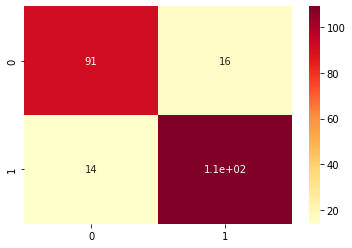

In [225]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, best_estimator.predict(X_test)), annot = True, cmap = "YlOrRd")

From the confusion matrix, we can derive that most of the errors (16) were made by classifying healthy people as diseased, i.e. false positives. At the same time, 14 patients were considered healthy when they actually had heart disease, i.e., a false negative. In the medical environment, we want to reduce the number of false negative predictions since we want to identify the disease and treat it (when incorrectly diagnosing a person with the disease can be corrected by further testing). Hence, if we work further on improving the model, we would want to focus on decreasing the number of false negative cases.

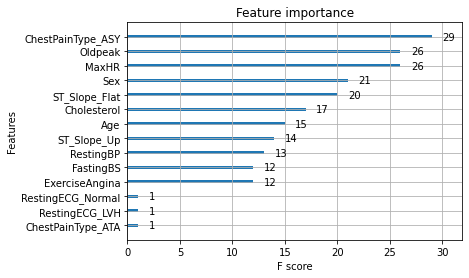

In [226]:
from xgboost import plot_importance
plot_importance(best_estimator, )

Surprisingly, **ChestPainType_ASY** is the most important feature when modelling with XGBoost. It makes sense, since we saw on the graphs during EDA that chest pain asymptomatic patients do have high proportion of heart disease cases. From heat map, we saw that there was a corralation between **Heart Disease** and **Oldpeak**/**MaxHr**, so it makes sense that those features are also important.

On the other hand, indicator variables for ATA and NAP chest pain had lower importance in the model, which makes sense in the context, since they had similar distributions and counts.

Overall, we found that XGBoost has the best performance among the models and hyperparameters we tested, with a test accuracy of 87%. The most important features that impact classification are **ChestPainType_ASY**, **MaxHR** and **OldPeak**.